## Imports

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, mannwhitneyu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from math import ceil
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix

## Data

In [3]:
BC_data = pd.read_csv('dataR2.csv')
BC_data['Classification'] = BC_data['Classification'].apply(lambda x: 0 if x == 1 else 1)

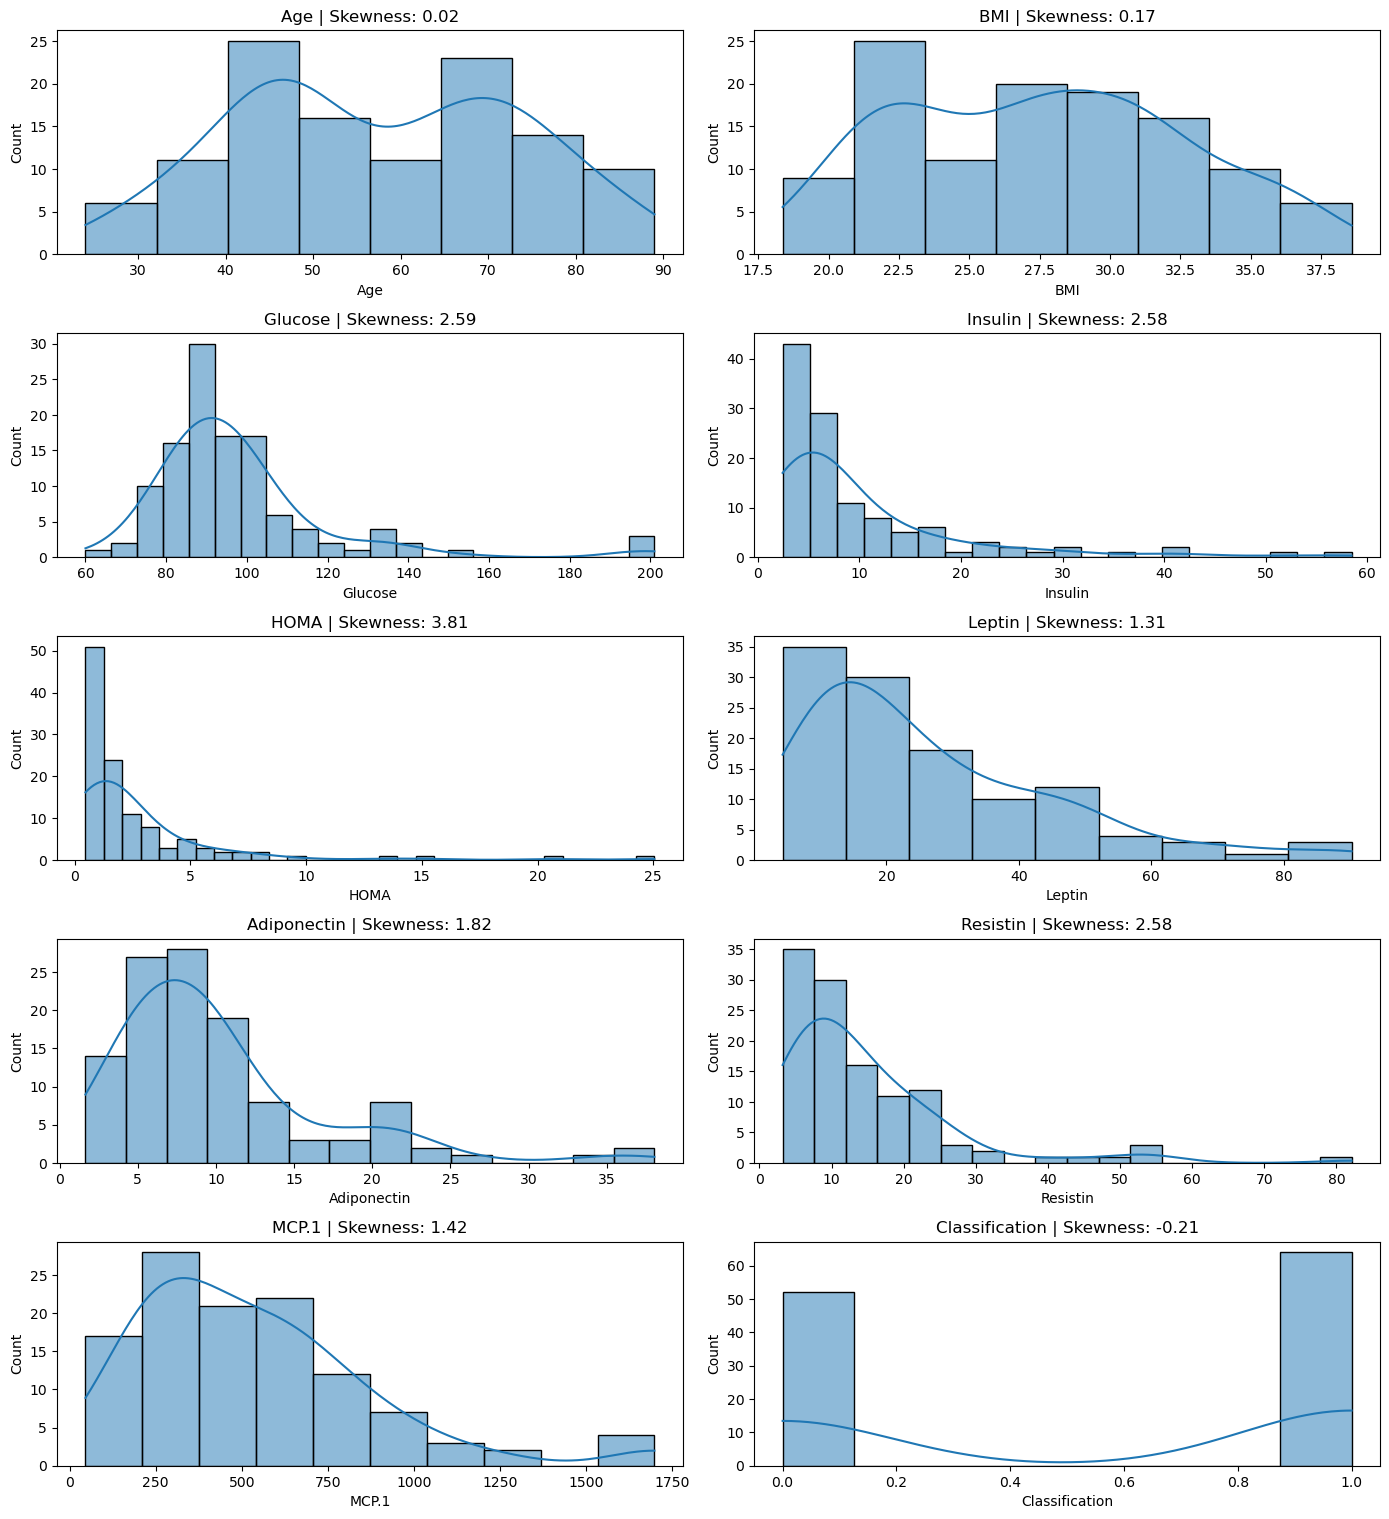

In [4]:
Numerical_Columns = BC_data.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(Numerical_Columns) * 3))

for idx, feature in enumerate(Numerical_Columns, 1):
    plt.subplot(len(Numerical_Columns), 2, idx)
    sns.histplot(BC_data[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(BC_data[feature].skew(), 2)}")
    
plt.tight_layout()
plt.show()


## Univariant

**_Shapiro-Wilk Test_**

In [8]:
quantitative_vars =  BC_data.select_dtypes(include=["number"]).columns.tolist()
quantitative_vars = [var for var in quantitative_vars if var != 'Classification']

print(quantitative_vars)

['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1']


In [12]:
shapiro_results = {}
for var in quantitative_vars:
    stat, p_value = shapiro(BC_data[var])
    shapiro_results[var] = {'Statistic': stat, 'p-value': p_value}

for var, result in shapiro_results.items():
    p_value = result['p-value']
    status = "Does not follow a normal distribution" if p_value < 0.05 else "Follows a normal distribution"
    print(f"{var}: p-value={p_value:.4e} → {status}")



Age: p-value=8.9329e-03 → Does not follow a normal distribution
BMI: p-value=7.6534e-03 → Does not follow a normal distribution
Glucose: p-value=1.2015e-12 → Does not follow a normal distribution
Insulin: p-value=1.5076e-14 → Does not follow a normal distribution
HOMA: p-value=4.3002e-17 → Does not follow a normal distribution
Leptin: p-value=1.1868e-08 → Does not follow a normal distribution
Adiponectin: p-value=2.7649e-10 → Does not follow a normal distribution
Resistin: p-value=6.7052e-13 → Does not follow a normal distribution
MCP.1: p-value=5.0768e-08 → Does not follow a normal distribution


**_Mann-Whitney U Test_**

In [14]:
mannwhitneyUresults = []

for var in quantitative_vars:
    cancer_group = BC_data[BC_data['Classification'] == 1][var]  # Group with Cancer (assuming 1 is Cancer)
    non_cancer_group = BC_data[BC_data['Classification'] == 0][var]  # Group without Cancer (assuming 0 is Non-Cancer)
    
    stat, p_value = mannwhitneyu(cancer_group, non_cancer_group)
    
    significance = "Significant" if p_value < 0.05 else "Not Significant"
    
    mannwhitneyUresults.append({
        'Variable': var,
        'p-value': p_value,
        'Significance': significance
    })

results_BC = pd.DataFrame(mannwhitneyUresults)
print(results_BC.to_markdown(index=False))

| Variable    |     p-value | Significance    |
|:------------|------------:|:----------------|
| Age         | 0.478881    | Not Significant |
| BMI         | 0.201656    | Not Significant |
| Glucose     | 1.01872e-06 | Significant     |
| Insulin     | 0.0265674   | Significant     |
| HOMA        | 0.00289805  | Significant     |
| Leptin      | 0.949096    | Not Significant |
| Adiponectin | 0.766464    | Not Significant |
| Resistin    | 0.00186086  | Significant     |
| MCP.1       | 0.50352     | Not Significant |


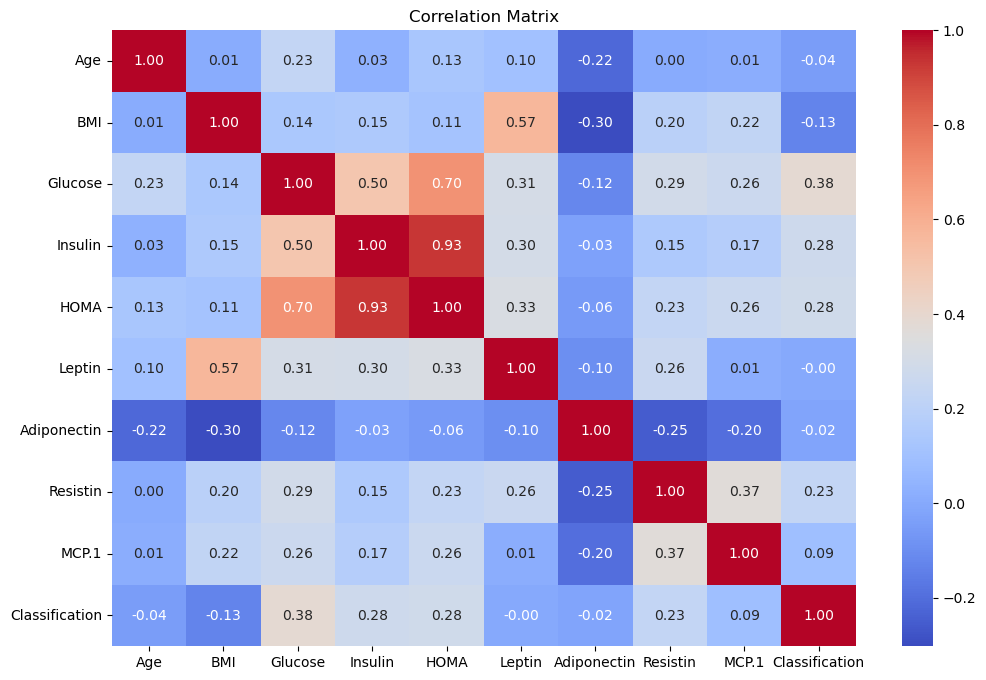

In [16]:
correlation_matrix = BC_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


**_ROC Analysis_**

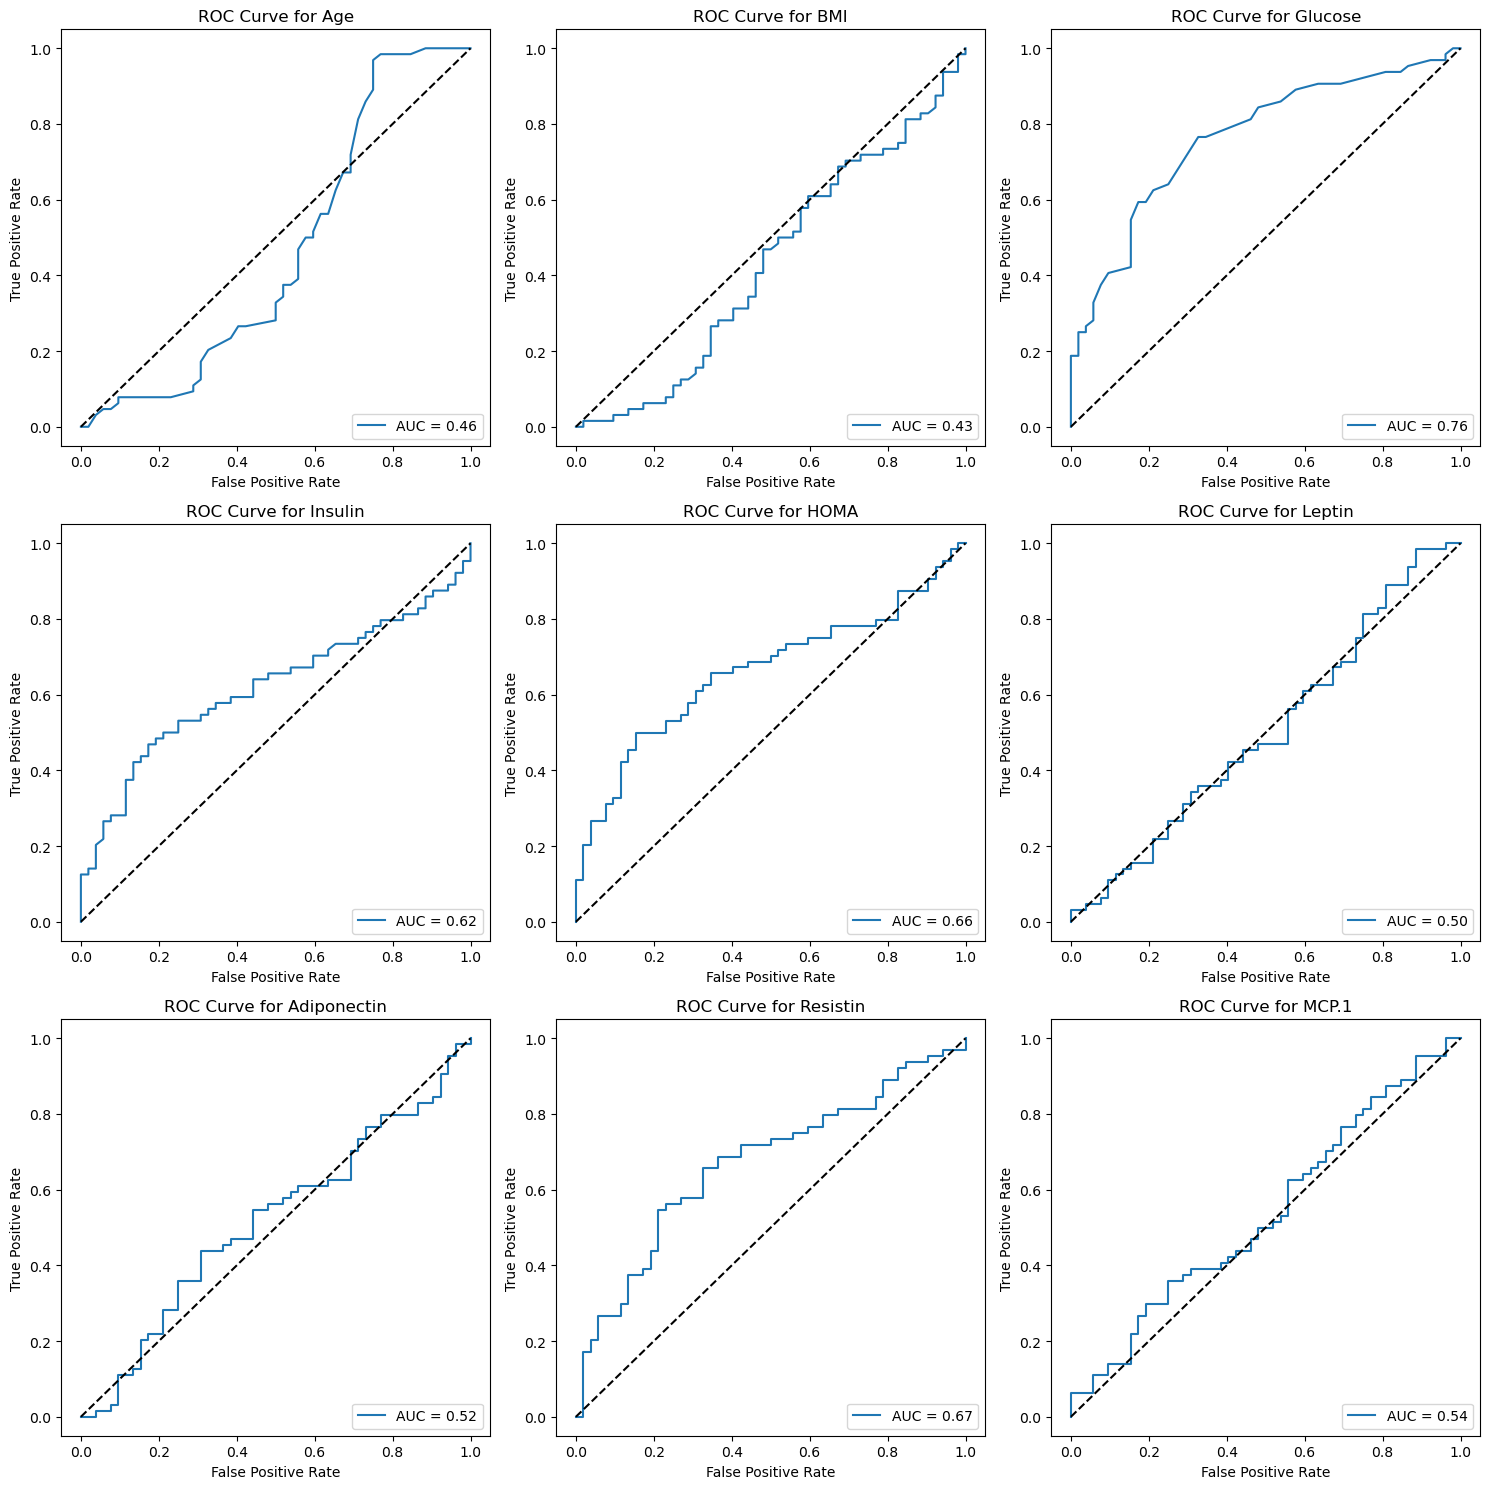

In [22]:
num_vars = len(quantitative_vars)
cols = 3 
rows = ceil(num_vars / cols)

y_true = BC_data['Classification']

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5)) 
axes = axes.flatten()  

auc_values = []
significant_auc_values = []

for i, var in enumerate(quantitative_vars):
    y_score = BC_data[var]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    auc_values.append(roc_auc)

    if roc_auc > 0.5:
        significant_auc_values.append(((var, fpr, tpr, thresholds, roc_auc)))


    ax = axes[i]
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')  
    ax.set_title(f'ROC Curve for {var}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

for j in range(len(quantitative_vars), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


**_Youden Index_**

In [26]:
youden_indices = {}

for var, fpr, tpr, thresholds, roc_auc in significant_auc_values:
    youden_index = tpr - fpr  # Sensitivity - (1 - Specificity)
    max_youden_index = max(youden_index)
    optimal_idx = youden_index.argmax()
    optimal_threshold = thresholds[youden_index.argmax()]

    optimal_sensitivity = tpr[optimal_idx]  # True Positive Rate
    optimal_specificity = 1 - fpr[optimal_idx]  # True Negative Rate
    
    youden_indices[var] = (max_youden_index, optimal_threshold)
    
    print(f"{var}: Youden Index = {max_youden_index:.3f}, Optimal Threshold = {optimal_threshold:.3f}, "
          f"Sensitivity = {optimal_sensitivity:.3f}, Specificity = {optimal_specificity:.3f}")

Glucose: Youden Index = 0.439, Optimal Threshold = 92.000, Sensitivity = 0.766, Specificity = 0.673
Insulin: Youden Index = 0.296, Optimal Threshold = 8.808, Sensitivity = 0.469, Specificity = 0.827
HOMA: Youden Index = 0.346, Optimal Threshold = 2.242, Sensitivity = 0.500, Specificity = 0.846
Leptin: Youden Index = 0.100, Optimal Threshold = 7.648, Sensitivity = 0.984, Specificity = 0.115
Adiponectin: Youden Index = 0.130, Optimal Threshold = 9.760, Sensitivity = 0.438, Specificity = 0.692
Resistin: Youden Index = 0.335, Optimal Threshold = 13.742, Sensitivity = 0.547, Specificity = 0.788
MCP.1: Youden Index = 0.109, Optimal Threshold = 635.049, Sensitivity = 0.359, Specificity = 0.750


## MultiVarient Test

**Variable Selection**

In [34]:
feature_names = quantitative_vars

X = BC_data[quantitative_vars].values
Y = BC_data['Classification'].values

rf_model = RandomForestClassifier(random_state=32, n_estimators=100)
rf_model.fit(X, Y)

feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance Rankings:")
print(feature_importance_df)


Feature Importance Rankings:
       Feature  Importance
2      Glucose    0.200903
7     Resistin    0.135005
0          Age    0.131678
1          BMI    0.121064
4         HOMA    0.106933
3      Insulin    0.088558
5       Leptin    0.081454
6  Adiponectin    0.075381
8        MCP.1    0.059024


**Classification Algorithim**

In [36]:
sorted_features = feature_importance_df.sort_values(by="Importance", ascending=False)["Feature"].tolist()
print(sorted_features)

['Glucose', 'Resistin', 'Age', 'BMI', 'HOMA', 'Insulin', 'Leptin', 'Adiponectin', 'MCP.1']


In [42]:
n_iter = 50
n_values = [2, 3, 4, 5, 6, 9]  
results = []

for n in n_values:
    selected_features = sorted_features[:n]
    print(f"Testing Top-{n} Features: {selected_features}")
    
    X_subset = BC_data[selected_features]
    y = BC_data['Classification']
    
    model_metrics = {model_name: {"accuracy": [], "auc": [], "sensitivity": [], "specificity": []} 
                     for model_name in ["Logistic Regression", "SVM", "Random Forest"]}
    
    for i in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=i)
        
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "SVM": SVC(kernel='rbf', C=1, gamma='scale',probability=True),
            "Random Forest": RandomForestClassifier(random_state=32),
        }
        
        for model_name, model in models.items():
            model.fit(X_train, y_train) 
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
            
            accuracy = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)
            sensitivity = recall_score(y_test, y_pred, pos_label=1)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            specificity = tn / (tn + fp) 
            
            # Store metrics
            model_metrics[model_name]["accuracy"].append(accuracy)
            model_metrics[model_name]["auc"].append(auc)
            model_metrics[model_name]["sensitivity"].append(sensitivity)
            model_metrics[model_name]["specificity"].append(specificity)
    
    for model_name, metrics in model_metrics.items():
        results.append({
            "Model": model_name,
            "n_features": n,
            "Features": selected_features,
            "Mean Accuracy": np.mean(metrics["accuracy"]),
            "Std Accuracy": np.std(metrics["accuracy"]),
            "Mean AUC": np.mean(metrics["auc"]),
            "Std AUC": np.std(metrics["auc"]),
            "Mean Sensitivity": np.mean(metrics["sensitivity"]),
            "Mean Specificity": np.mean(metrics["specificity"]),
        })

results_df = pd.DataFrame(results)
print(results_df)


Testing Top-2 Features: ['Glucose', 'Resistin']
Testing Top-3 Features: ['Glucose', 'Resistin', 'Age']
Testing Top-4 Features: ['Glucose', 'Resistin', 'Age', 'BMI']
Testing Top-5 Features: ['Glucose', 'Resistin', 'Age', 'BMI', 'HOMA']
Testing Top-6 Features: ['Glucose', 'Resistin', 'Age', 'BMI', 'HOMA', 'Insulin']
Testing Top-9 Features: ['Glucose', 'Resistin', 'Age', 'BMI', 'HOMA', 'Insulin', 'Leptin', 'Adiponectin', 'MCP.1']
                  Model  n_features  \
0   Logistic Regression           2   
1                   SVM           2   
2         Random Forest           2   
3   Logistic Regression           3   
4                   SVM           3   
5         Random Forest           3   
6   Logistic Regression           4   
7                   SVM           4   
8         Random Forest           4   
9   Logistic Regression           5   
10                  SVM           5   
11        Random Forest           5   
12  Logistic Regression           6   
13                  SVM

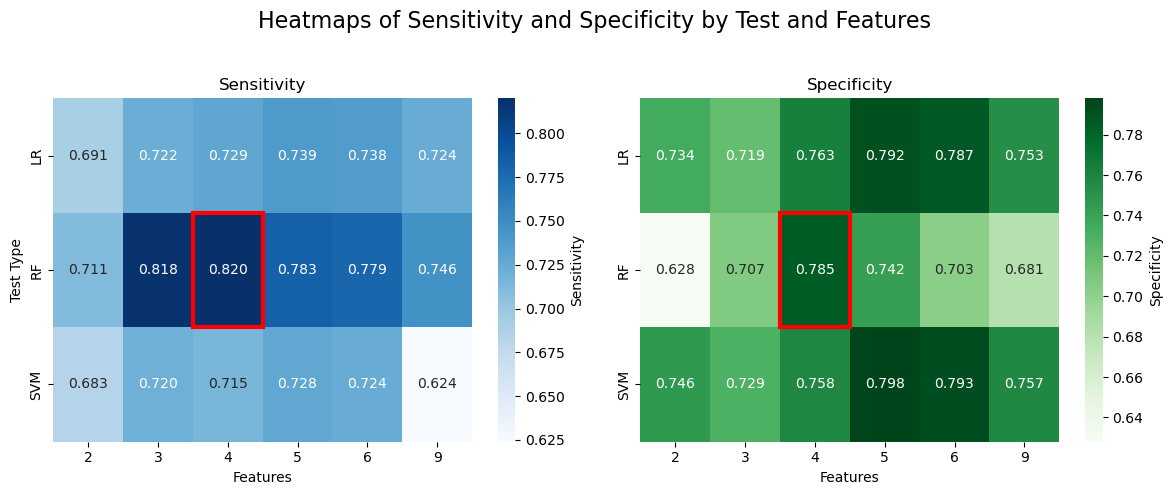

In [43]:
data = pd.DataFrame({
    'Test Type': ['LR', 'SVM', 'RF'] * 6,
    'Features': ['2', '2', '2', '3', '3', '3', '4', '4', '4', '5', '5', '5', '6', '6', '6', '9', '9', '9'],
    'Mean Sensitivity': [0.691, 0.683, 0.711, 0.722, 0.720, 0.818, 0.729, 0.715, 0.820, 0.739, 0.728, 0.783,
                         0.738, 0.724, 0.779, 0.724, 0.624, 0.746],
    'Mean Specificity': [0.734, 0.746, 0.628, 0.719, 0.729, 0.707, 0.763, 0.758, 0.785, 0.792, 0.798, 0.742,
                         0.787, 0.793, 0.703, 0.753, 0.757, 0.681]
})

sensitivity_pivot = data.pivot(index="Test Type", columns="Features", values="Mean Sensitivity")
specificity_pivot = data.pivot(index="Test Type", columns="Features", values="Mean Specificity")

best_row, best_col = 'RF', '4'

plt.figure(figsize=(12, 5))
plt.suptitle("Heatmaps of Sensitivity and Specificity by Test and Features", fontsize=16)

plt.subplot(1, 2, 1)
ax1 = sns.heatmap(sensitivity_pivot, annot=True, cmap="Blues", cbar_kws={'label': 'Sensitivity'}, fmt=".3f")
plt.title("Sensitivity")
plt.xlabel("Features")
plt.ylabel("Test Type")

x, y = list(sensitivity_pivot.columns).index(best_col), list(sensitivity_pivot.index).index(best_row)
ax1.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=3))

plt.subplot(1, 2, 2)
ax2 = sns.heatmap(specificity_pivot, annot=True, cmap="Greens", cbar_kws={'label': 'Specificity'}, fmt=".3f")
plt.title("Specificity")
plt.xlabel("Features")
plt.ylabel("")

x, y = list(specificity_pivot.columns).index(best_col), list(specificity_pivot.index).index(best_row)
ax2.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=3))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



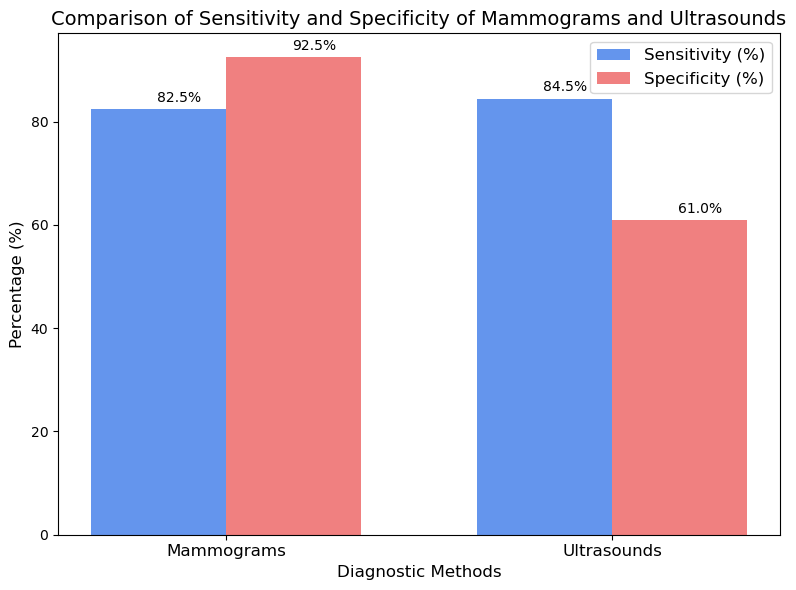

In [54]:
methods = ['Mammograms', 'Ultrasounds']

sensitivity_avg = [82.5, 84.5] 
specificity_avg = [92.5, 61] 

sensitivity_min = [75, 80]  
sensitivity_max = [90, 89]

specificity_min = [90, 33]  
specificity_max = [95, 88]


x = np.arange(len(methods))

bar_width = 0.35


fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - bar_width/2, sensitivity_avg, bar_width, label='Sensitivity (%)', color='cornflowerblue', capsize=5)
bars2 = ax.bar(x + bar_width/2, specificity_avg, bar_width, label='Specificity (%)', color='lightcoral', capsize=5)

ax.set_xlabel('Diagnostic Methods', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Comparison of Sensitivity and Specificity of Mammograms and Ultrasounds', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=12)
ax.legend(fontsize=12)

for bars, avg_values in zip([bars1, bars2], [sensitivity_avg, specificity_avg]):
    for bar, avg in zip(bars, avg_values):
        height = bar.get_height()
        ax.annotate(f'{avg:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(15, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


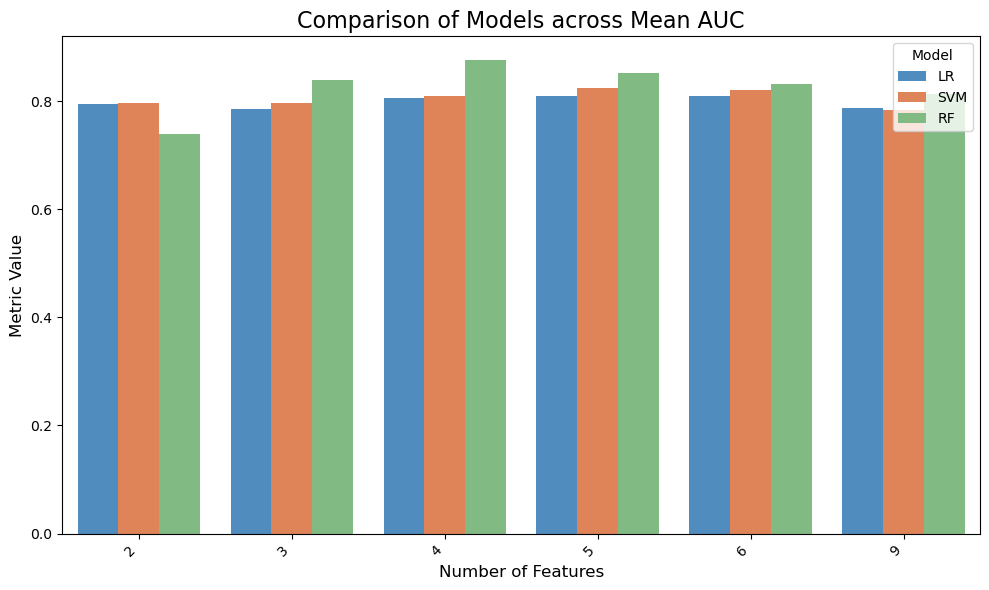

In [56]:
data = pd.DataFrame({
    'Features': ['2', '2', '2', '3', '3', '3', '4', '4', '4', '5', '5', '5', '6', '6', '6', '9', '9', '9'],
    'Model': ['LR', 'SVM', 'RF', 'LR', 'SVM', 'RF', 'LR', 'SVM', 'RF', 'LR', 'SVM', 'RF', 'LR', 'SVM', 'RF', 'LR', 'SVM', 'RF'],
    'Mean Accuracy': [0.707, 0.708, 0.669, 0.717, 0.719, 0.763, 0.741, 0.732, 0.799, 0.761, 0.758, 0.758, 0.758, 0.754, 0.739, 0.735, 0.710, 0.712],
    'Mean AUC': [0.794, 0.797, 0.739, 0.785, 0.797, 0.839, 0.805, 0.809, 0.876, 0.809, 0.824, 0.852, 0.809, 0.821, 0.832, 0.787, 0.784, 0.814]
})

metrics = ['Mean AUC']
melted_data = pd.melt(data, id_vars=['Features', 'Model'], value_vars=metrics, var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))

rich_palette = ["#3e8ecf", "#f57c42", "#78c379"]  # Deeper blue, orange, and green

sns.barplot(x="Features", y="Value", hue="Model", data=melted_data, errorbar=None, palette=rich_palette)

plt.title("Comparison of Models across Mean AUC", fontsize=16)
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(title="Model")
plt.show()
